In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import jit
from pixelgrid import *
from psfmodel import *

In [2]:
import numpyro
import numpyro.distributions as dist
import matplotlib.pyplot as plt
from jax import random
from jax.config import config
config.update('jax_enable_x64', True)

In [3]:
reduce = 1

#%% obs grid
Nx, Ny = 30 // reduce, 30 // reduce
pix = PixelGrid(0, Nx, 0, Ny)

#%% true grid (oversample)
oversample_true = 10
spix = PixelGrid(0, Nx, 0, Ny, dx=1./oversample_true, dy=1./oversample_true)

In [4]:
M, N = spix.X.shape
K, L = oversample_true, oversample_true
MK, NL = M // K, N // L
@jit
def super_to_obs(Zsuper):
    return Zsuper[:MK*K, :NL*L].reshape(MK, K, NL, L).sum(axis=(1, 3))

In [5]:
truepsffunc = gaussian_psf

In [6]:
Nsource = 10
np.random.seed(124)
xcenters = np.random.rand(Nsource)*Nx
ycenters = np.random.rand(Nsource)*Ny
truepsfkws = {"sigma": 1. / reduce}

In [7]:
def super_image(spix, xcenters, ycenters, psffunc, **kwargs):
    ret = np.zeros_like(spix.X)
    for x, y in zip(xcenters, ycenters):
        sZ = truepsffunc(spix.X, spix.Y, x, y, **kwargs)
        ret += sZ / jnp.sum(sZ)
    return np.array(ret)

def plot2d(Z, pix, xcenters=None, ycenters=None, title=None):
    plt.imshow(Z, origin='lower', extent=(pix.xmin, pix.xmax, pix.ymin, pix.ymax))
    plt.xlabel("x pixel")
    plt.ylabel("y pixel")
    if xcenters is not None:
        for x, y in zip(xcenters, ycenters):
            plt.axvline(x=x, color='gray', lw=1, alpha=0.5)
            plt.axhline(y=y, color='gray', lw=1, alpha=0.5)
    if title is not None:
        plt.title(title)
    plt.colorbar();

In [8]:
Zs = super_image(spix, xcenters, ycenters, truepsffunc, **truepsfkws)

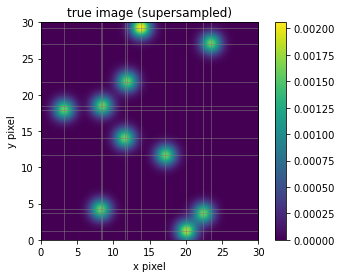

In [9]:
plot2d(Zs, spix, xcenters=xcenters, ycenters=ycenters, title="true image (supersampled)")

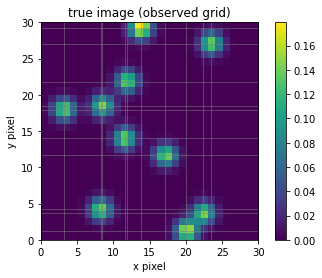

In [10]:
Z = super_to_obs(Zs)
plot2d(Z, pix, xcenters=xcenters, ycenters=ycenters, title="true image (observed grid)")

In [11]:
np.random.seed(123)
sigmaerr = 2e-3
Zerr = np.random.randn(*np.shape(Z))*sigmaerr
Zobs = Z + Zerr

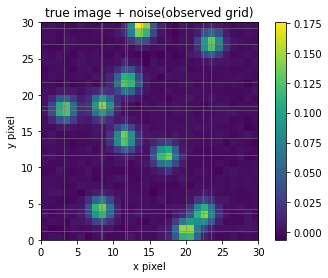

In [12]:
plot2d(Zobs, pix, xcenters=xcenters, ycenters=ycenters, title="true image + noise(observed grid)")

In [13]:
drx = pix.X1d[:,None] - xcenters
dry = pix.Y1d[:,None] - ycenters
dR2 = drx**2 + dry**2
staridx1d = np.argmin(dR2, axis=1)
drx = jnp.diag(drx[:,staridx1d])
dry = jnp.diag(dry[:,staridx1d])

In [14]:
def gpmodel(Z, sigmaerr, xcenters, ycenters):
    ones = jnp.ones_like(xcenters)
    
    x = numpyro.sample("x", dist.Uniform(low=xcenters[1:]-3, high=xcenters[1:]+3))
    y = numpyro.sample("y", dist.Uniform(low=ycenters[1:]-3, high=ycenters[1:]+3))
    xc = jnp.r_[xcenters[0], x]
    yc = jnp.r_[ycenters[0], y]
   
    lnlenx = numpyro.sample("lnlenx", dist.Uniform(low=-2, high=2))
    lnleny = numpyro.sample("lnleny", dist.Uniform(low=-2, high=2))
    lna = numpyro.sample("lna", dist.Uniform(low=-10, high=0))
    lenx, leny = jnp.exp(lnlenx), jnp.exp(lnleny)
    dx2 = jnp.power((drx[:,None]-drx[None,:]) / lenx, 2.0)
    dy2 = jnp.power((dry[:,None]-dry[None,:]) / leny, 2.0)
    kernel = jnp.exp(2*lna) * jnp.exp(-0.5*dx2-0.5*dy2)
    kernel += sigmaerr**2 * jnp.eye(pix.Nx*pix.Ny)
    numpyro.deterministic("kernel", kernel)
    
    mv = dist.MultivariateNormal(loc=0.0, covariance_matrix=kernel)    
    numpyro.sample("obs", mv, obs=Z.ravel())

In [15]:
kernel = numpyro.infer.NUTS(gpmodel)

In [35]:
nw, ns = 500, 500
mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns)

In [36]:
rng_key = random.PRNGKey(0)

In [37]:
mcmc.run(rng_key, Zobs, sigmaerr, xcenters, ycenters)

  0%|                                                                                                              | 0/1000 [00:00<?, ?it/s]/home/masuda/anaconda3/lib/python3.9/site-packages/jax/_src/tree_util.py:200: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
sample: 100%|█████████████████████████████████████████████████| 1000/1000 [03:16<00:00,  5.09it/s, 7 steps of size 5.22e-01. acc. prob=0.88]


In [38]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       lna     -4.31      0.05     -4.31     -4.39     -4.23    658.51      1.00
    lnlenx      0.30      0.03      0.31      0.26      0.34    555.22      1.00
    lnleny     -0.65      0.03     -0.65     -0.69     -0.60    989.09      1.00
      x[0]     22.34      1.80     22.22     19.40     24.77    655.73      1.00
      x[1]     17.19      1.74     17.26     14.73     20.02    684.80      1.00
      x[2]     13.72      1.68     13.76     11.11     16.29    701.93      1.00
      x[3]     11.50      1.71     11.49      8.55     13.95    841.43      1.00
      x[4]      8.23      1.80      8.30      5.27     10.64   1075.75      1.00
      x[5]     20.00      1.67     19.96     17.32     22.48    807.43      1.00
      x[6]     11.88      1.71     11.99      9.02     14.34    979.11      1.00
      x[7]      8.44      1.81      8.39      5.77     11.24    820.75      1.00
      x[8]     23.35      1

In [39]:
smp = mcmc.get_samples()

In [40]:
from numpyro.infer import Predictive
predictive = Predictive(gpmodel, mcmc.get_samples())

In [41]:
pred = predictive(random.PRNGKey(1), Z=Zobs, sigmaerr=sigmaerr, xcenters=xcenters, ycenters=ycenters)

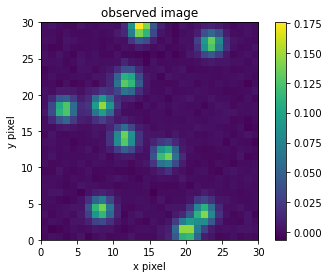

In [42]:
plot2d(Zobs, pix, title='observed image')

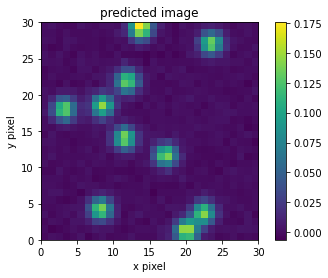

In [43]:
plot2d(np.mean(pred['obs'], axis=0).reshape(Nx,Ny), pix, title='predicted image')

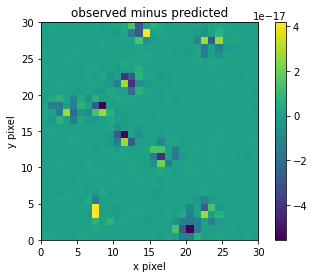

In [44]:
plot2d(Zobs-np.mean(pred['obs'], axis=0).reshape(Nx,Ny), pix, title='observed minus predicted')

In [45]:
shift = 0
xmean, xstd = np.mean(smp['x'], axis=0), np.std(smp['x'], axis=0)
ymean, ystd = np.mean(smp['y'], axis=0),np.std(smp['y'], axis=0)
dmax = np.r_[np.abs(xmean-xcenters[1:]-shift)+np.abs(xstd), np.abs(ymean-ycenters[1:]-shift)+np.abs(ystd)].max()

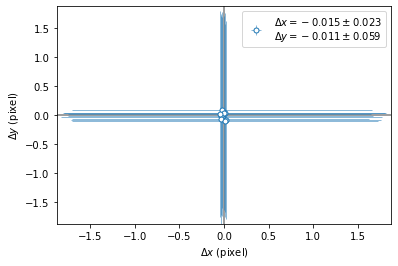

In [46]:
plt.figure()
plt.xlabel("$\Delta x$ (pixel)")
plt.ylabel("$\Delta y$ (pixel)")
plt.xlim(-dmax, dmax)
plt.ylim(-dmax, dmax)
plt.axvline(x=0, color='gray', zorder=-1000)
plt.axhline(y=0, color='gray', zorder=-1000)
dx = xmean-xcenters[1:]-shift
dy = ymean-ycenters[1:]-shift
plt.errorbar(dx, dy, xerr=xstd, yerr=ystd, fmt='o', mfc='white', lw=0.5, markersize=5,
            label="$\Delta x=%.3f\pm%.3f$\n$\Delta y=%.3f\pm%.3f$"%(np.mean(dx), np.std(dx), np.mean(dy), np.std(dy)))
plt.legend(loc='best')

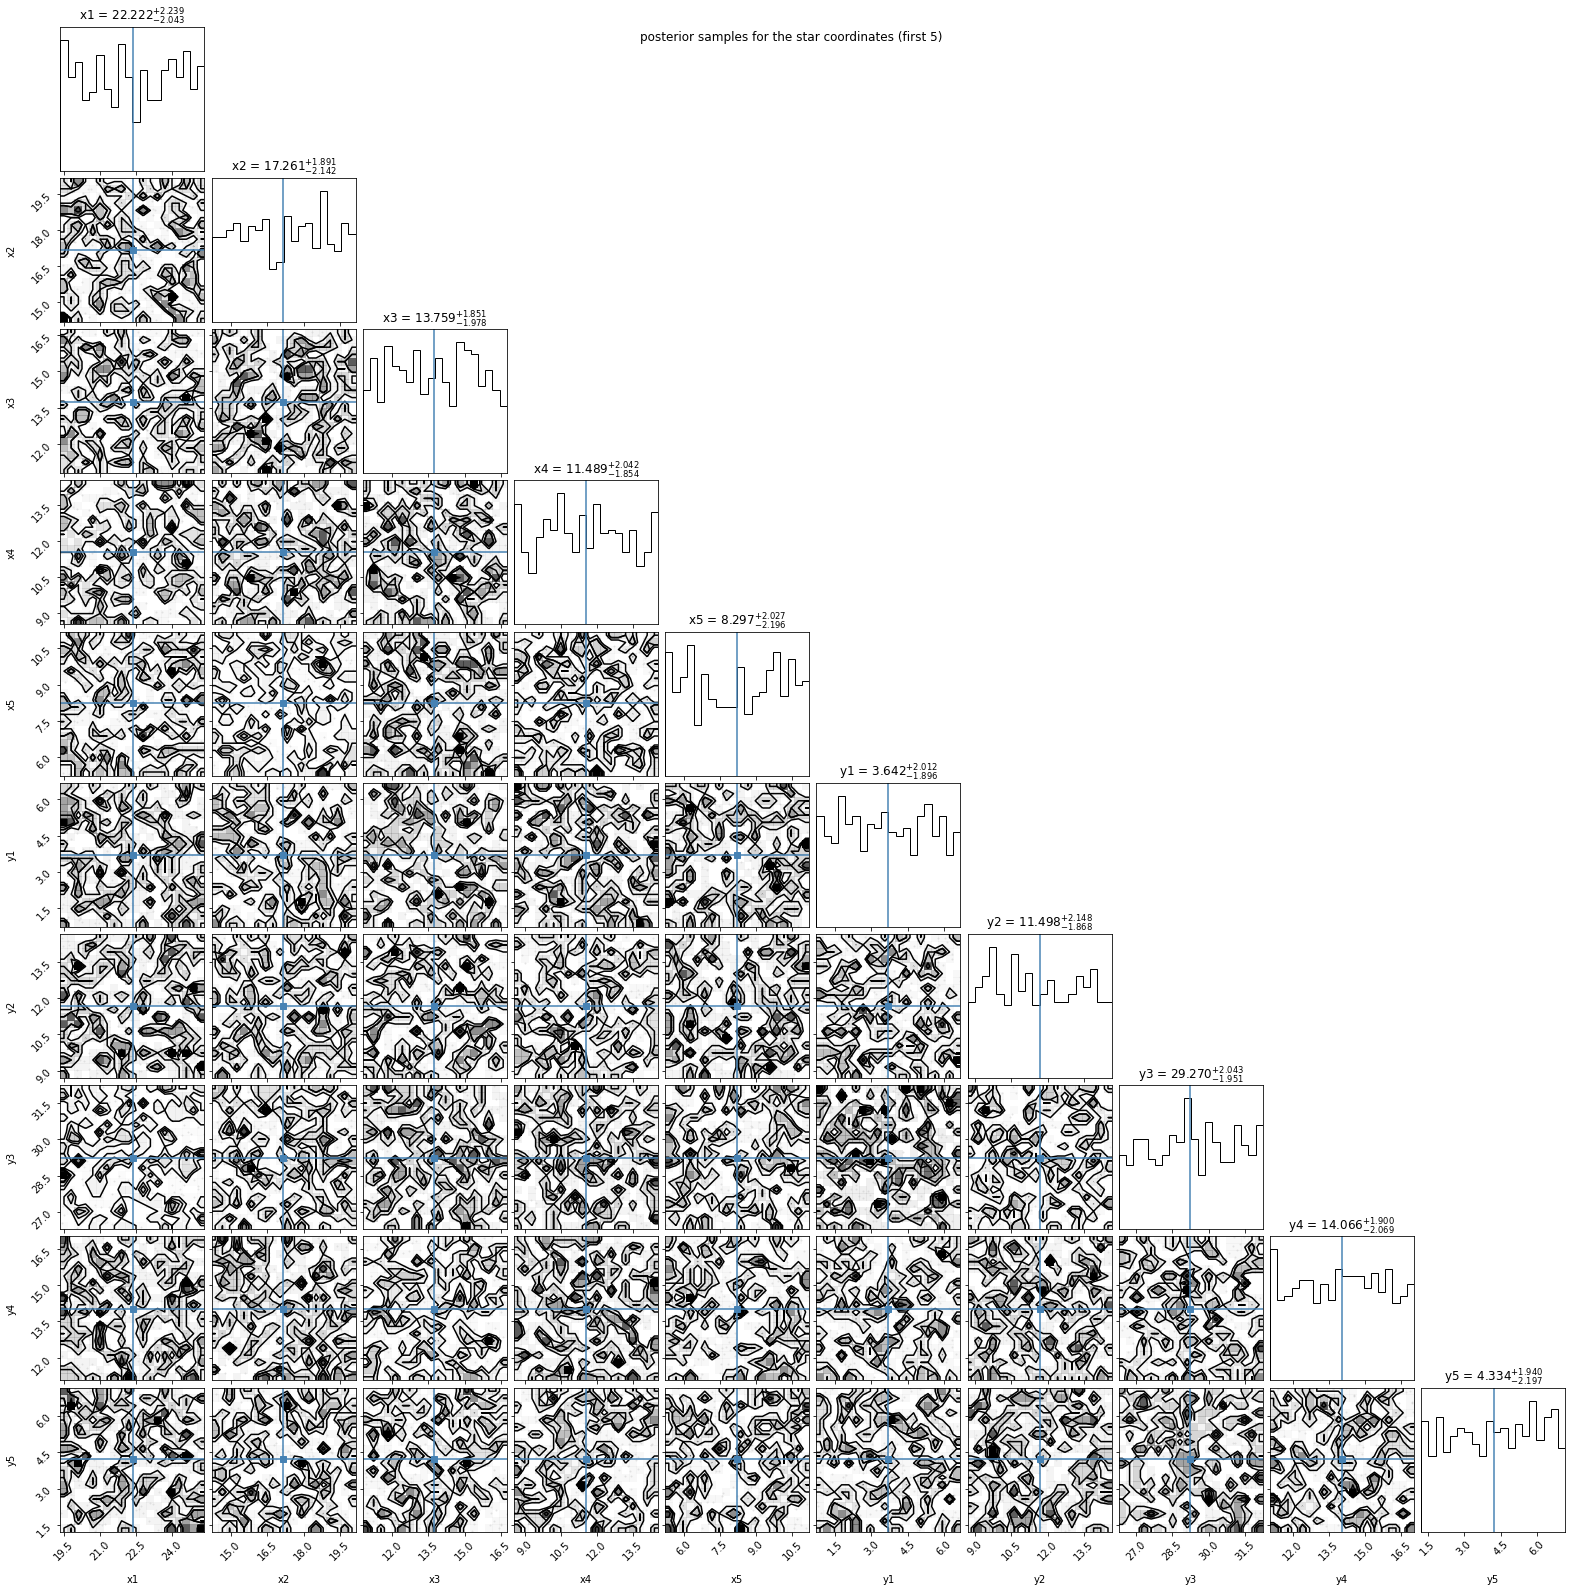

In [47]:
import corner
nplot = 5
fig = corner.corner(np.c_[np.array(smp['x'])[:,:nplot], np.array(smp['y'])[:,:nplot]], 
                    show_titles=True, title_fmt=".3f",
                    truths=np.r_[xcenters[1:][:nplot]+shift, ycenters[1:][:nplot]+shift],
                   labels=["x%d"%i for i in range(1,nplot+1)]+["y%d"%i for i in range(1,nplot+1)])
fig.suptitle("posterior samples for the star coordinates (first %d)"%nplot);

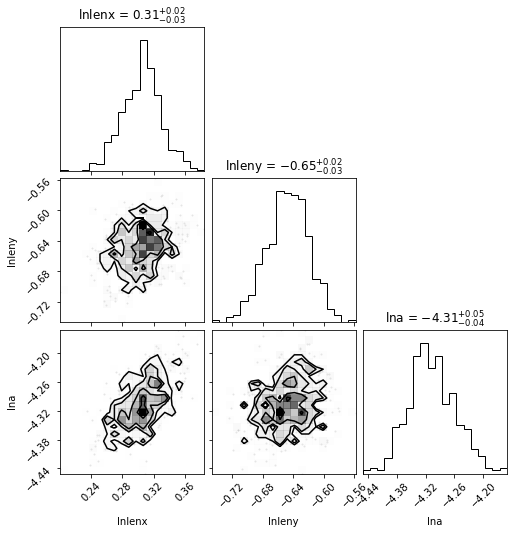

In [48]:
import pandas as pd
pnames = ["lnlenx", "lnleny", "lna"]
hyper = pd.DataFrame(data=dict(zip(pnames, [smp[k] for k in pnames])))
fig = corner.corner(hyper, labels=pnames, show_titles="%.2f")